# TODO:

In obtain_plot, faccio il bilanciamento ad ogni livello di confidenza? È giusto?

Prova un validation set su paris e verifica che overfitti

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
from scipy import stats
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.evaluation import load_ricseq_splash_mario_results, map_signal_to_sigmoid_range, balance_df
from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from models.nt_classifier import build as build_model 
import util
from util.plot_utils import plot_confidence_based_on_distance, plot_tnr_based_on_distance, quantile_bins, collect_prec_npv_based_on_confidence_level_based_on_treshold, obtain_plot, collect_results_based_on_confidence_level_based_on_percentile, plot_length_embeddings_and_rnas, plot_intarna_Enorm_curves, plot_logs, plot_ROC_based_on_confidence, obtain_auc_and_perc_in_specific_treshold, get_policies_list, plot_results_based_on_treshold, plot_results_based_on_percentile, collect_results_based_on_confidence_level_based_on_treshold, plot_confs_and_accs, collect_prec_recall_sens_npv_based_on_confidence_level_based_on_percentile, calc_acc_for_each_class, plot_roc_curves, collect_results_based_on_confidence_level_how_many1, acc_for_each_class
import importlib
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [12]:
how = 'splash' # ricseq

only_test = False
exclude_train_genes = False
exclude_paris_genes = False
exclude_paris_couples = True

filter_hq_ricseq = False

MIN_N_READS_RICSEQ = 3

In [13]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', '/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningsplashRICSEQval0054') 

#all_modelarch2_easypretrain11_paristfinetuningSPLASHval0061
#all_modelarch2_easypretrain11_paristfinetuningsplashRICSEQval0054
#all_modelarch2_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054

In [14]:
# exclude the common genes
# gene_count = pd.concat([res.gene1_original, res.gene2_original]).value_counts()
# rare_genes = list(gene_count[gene_count<20].index)
# res = res[res.gene1_original.isin(rare_genes) & res.gene2_original.isin(rare_genes)]

In [15]:
test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))
res = load_ricseq_splash_mario_results(checkpoint_dir, test500, df_nt, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ)

# excluded couples:  56


# Depend on the length?

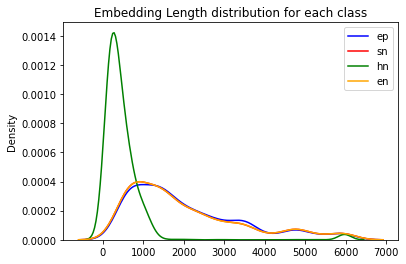

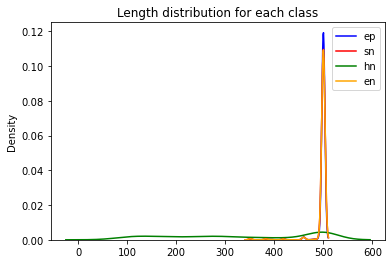

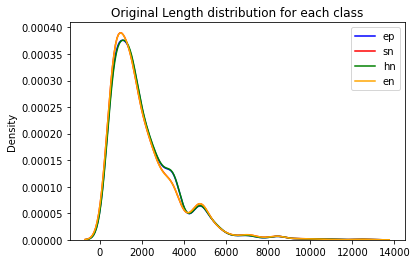

In [8]:
len_emb1 = res.g1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
len_emb2 = res.g2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
res['len_emb1'] = len_emb1[2].astype(int) - len_emb1[1].astype(int)
res['len_emb2'] = len_emb2[2].astype(int) - len_emb2[1].astype(int)

res['emebedding_area'] = res['len_emb1'] * res['len_emb2']

plot_length_embeddings_and_rnas(res)

<AxesSubplot:>

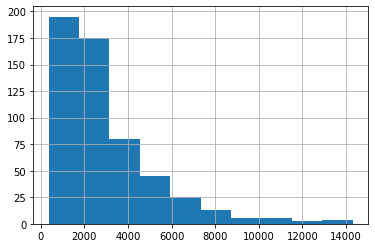

In [9]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))
df = pd.read_csv(os.path.join(processed_files_dir, f'{how}.csv'))
df_genes = df_genes[df_genes.gene_id.isin(set(df.gene1).union(df.gene2))].reset_index(drop = True)
df_genes[df_genes.length < 15_000].length.hist()

### Based on top-bottom

In [10]:
#create quantiles of interaction
df_int = df[(df.interacting)].reset_index(drop = True)
if how == 'ricseq':
    df_int = df_int[(df_int.n_reads>=MIN_N_READS_RICSEQ)].reset_index(drop = True)
    
df_int['original_area'] = df_int.length_1 * df_int.length_2
area_values = np.array(df_int.original_area)


N_percentiles_area = 3

perc_values = np.linspace(10, 100, N_percentiles_area + 1)


n_values = 12
MIN_PERC = 1
space = 'linear' 
plot_ens = False

task = 'patches' # interactors, patches

policies = get_policies_list(task)

percentile_based_plot=False
    
    
if percentile_based_plot:
    area_value2 = 0
    for perc_value in perc_values:

        area_value = np.quantile(area_values, perc_value/100)

        area_value1 = area_value2
        area_value2 = area_value
        subset = res[(res.original_area >= area_value1) & (res.original_area <= area_value2)].reset_index(drop = True)
        subset = subset[subset.policy.isin(policies)].reset_index(drop = True)

        #subset = balance_df(subset)
        print(f'area interval: [{int(area_value1)}, {int(area_value2)}]')

        if set(subset.policy.value_counts().index) == set(policies):

            plot_results_based_on_percentile(subset, task, MIN_PERC, space, n_values = 12, size_multiplier = 10, plot_ens = False)

            print('\n')

### Based on treshold

In [11]:
balance_at_the_beginning = True
plot_ens = False

task = 'interactors' #interactors, patches

policies = get_policies_list(task)

N_percentiles_area = 2

perc_values = np.linspace(10, 100, N_percentiles_area + 1)


area_value2 = 0
for perc_value in perc_values:
    
    area_value = np.quantile(area_values, perc_value/100)

    area_value1 = area_value2
    area_value2 = area_value
    subset = res[(res.original_area >= area_value1) & (res.original_area <= area_value2)].reset_index(drop = True)
    subset = subset[subset.policy.isin(policies)].reset_index(drop = True)
    
    print(f'area interval: [{int(area_value1)}, {int(area_value2)}]')
    
    if set(subset.policy.value_counts().index) == set(policies):
        
        if balance_at_the_beginning:
            subset = balance_df(subset).reset_index(drop = True)
            
        MIN_SAMPLES = int((subset.shape[0] * MIN_PERC) / 100)
        
        plot_results_based_on_treshold(subset, task, MIN_PERC, MIN_SAMPLES, n_values = 12, size_multiplier = 10, plot_ens = plot_ens)
        
        print('\n')

area interval: [0, 759543]


ValueError: y_true takes value in {} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [ ]:
#create quantiles of interaction
df_int = df[(df.interacting)].reset_index(drop = True)
if how == 'ricseq':
    df_int = df_int[(df_int.n_reads>=MIN_N_READS_RICSEQ)].reset_index(drop = True)
df_int['original_area'] = df_int.length_1 * df_int.length_2
area_values = np.array(df_int.original_area)


balance_at_the_beginning = True


task = 'interactors' #interactors, patches
policies = get_policies_list(task)


plot_ens = False


MIN_PERC = 1


area_values_plot = [[0, 1_000**2], [1_000**2, 4_000**2], [4_000**2, 6_000**2], [6_000**2, 2_000_000**2]]

for (area_value1, area_value2) in area_values_plot:
    subset = res[(res.original_area >= area_value1) & (res.original_area <= area_value2)].reset_index(drop = True)
    subset = subset[subset.policy.isin(policies)].reset_index(drop = True)
    
    perc_of_total_df = df_int[(df_int.original_area >= area_value1) & (df_int.original_area <= area_value2)].shape[0]/df_int.shape[0] * 100
    print('perc of data in this interval: ', np.round(perc_of_total_df))
    
    print(f'area interval: [{int(area_value1)}, {int(area_value2)}]')

    if set(subset.policy.value_counts().index) == set(policies):
        
        
        if balance_at_the_beginning:
            subset = balance_df(subset).reset_index(drop = True)
            
        MIN_SAMPLES = int((subset.shape[0] * MIN_PERC) / 100)
        
        plot_results_based_on_treshold(subset, task, MIN_PERC, MIN_SAMPLES, n_values = 12, size_multiplier = 10, plot_ens = plot_ens)
        
        print('\n')

# PLOTS

## Metrics

In [14]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

0    17641
1     8068
Name: prediction, dtype: int64


0    24847
1      862
Name: ground_truth, dtype: int64


In [15]:
n_conf = 10

In [16]:
#obtain_plot(balance_df(res), n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

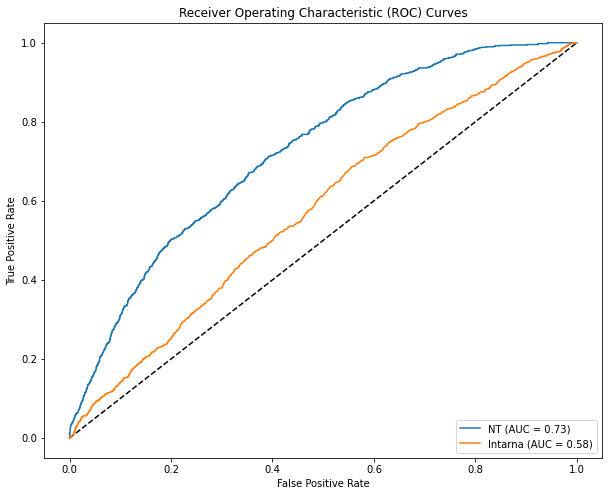

In [17]:
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT'},
                 {'prob': abs(res.E_norm), 'model_name': 'Intarna'}
                ], res.ground_truth)

In [18]:
# no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

# obtain_plot(balance_df(no_pc), n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

0.5667517401392111


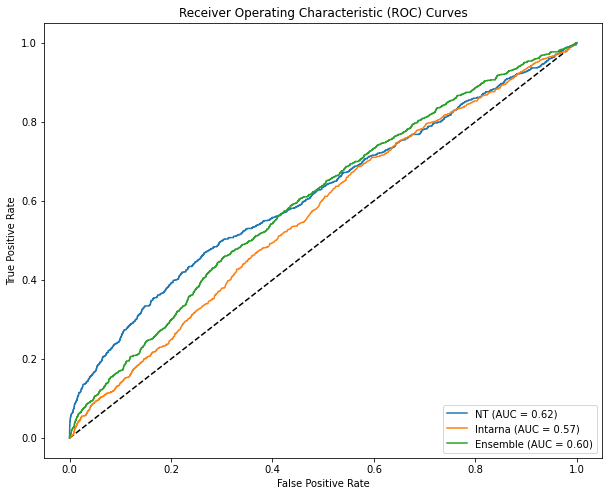

In [19]:
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])]
balanced_epsn = balance_df(easypos_smartneg)

print(balanced_epsn[balanced_epsn.ground_truth == balanced_epsn.prediction].shape[0]/balanced_epsn.shape[0])

#obtain_plot(balanced_epsn, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)
plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(easypos_smartneg.ensemble_score), 'model_name': 'Ensemble'},
                ], easypos_smartneg.ground_truth)

0.532542372881356


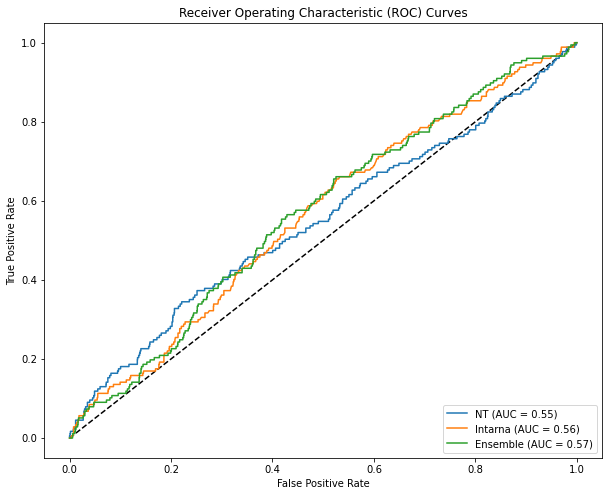

In [20]:
min_len_matrix = 5_000

big_epsn = easypos_smartneg[(easypos_smartneg.original_length1>min_len_matrix) & (easypos_smartneg.original_length2>min_len_matrix)]
big_epsn = balance_df(big_epsn)

print(big_epsn[big_epsn.ground_truth == big_epsn.prediction].shape[0]/big_epsn.shape[0])

#obtain_plot(big_epsn, n_original_df = res.shape[0], title = f'Metrics: BIG RNA-RNA recall is the accuracy of easypos, specificity is the accuracy of smartneg', n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': big_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(big_epsn.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(big_epsn.ensemble_score), 'model_name': 'Ensemble'},
                ], big_epsn.ground_truth)

0.531625


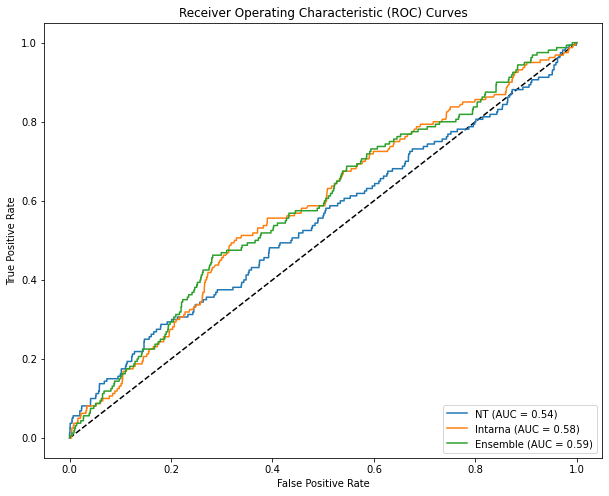

In [21]:
test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))
assert test500.shape[0] == df_nt[['couples', 'interacting', 'policy']].merge(test500, on = 'couples').shape[0]
if how == 'ricseq':
    test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']].merge(test500, on = 'couples')
    ids_to_keep = set(test500[test500.n_reads >= MIN_N_READS_RICSEQ].couples).union(test500[test500.interacting==False].couples)
    res = res[res.id_sample.isin(ids_to_keep)]
elif how == 'mario':
    test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']].merge(test500, on = 'couples')
elif how == 'splash':
    test500 = df_nt[['couples', 'interacting', 'policy', 'where', 'where_x1', 'where_y1', 'experiment']].merge(test500, on = 'couples')
else:
    raise NotImplementedError
id_cds_cds = set(test500[test500['where'] == 'CDS-CDS'].couples)




easypos_smartneg_balanced = balance_df(easypos_smartneg[easypos_smartneg.id_sample.isin(id_cds_cds)])

print((easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0])

#obtain_plot(easypos_smartneg_balanced, n_original_df = res.shape[0], title = f'Metrics: CDS-CDS recall is the accuracy of easypos, specificity is the accuracy of smartneg',  n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': easypos_smartneg_balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg_balanced.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(easypos_smartneg_balanced.ensemble_score), 'model_name': 'Ensemble'},
                ], easypos_smartneg_balanced.ground_truth)

0.5777207977207978


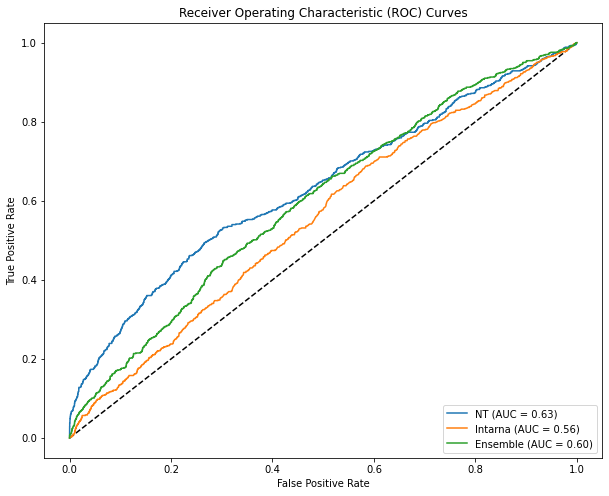

In [22]:
easypos_smartneg_balanced = balance_df(easypos_smartneg[~easypos_smartneg.id_sample.isin(id_cds_cds)])

print((easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0])


#obtain_plot(easypos_smartneg_balanced, n_original_df = res.shape[0], title = f'Metrics: NO CDS-CDS recall is the accuracy of easypos, specificity is the accuracy of smartneg', n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': easypos_smartneg_balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg_balanced.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(easypos_smartneg_balanced.ensemble_score), 'model_name': 'Ensemble'},
                ], easypos_smartneg_balanced.ground_truth)

0.6173177842565598


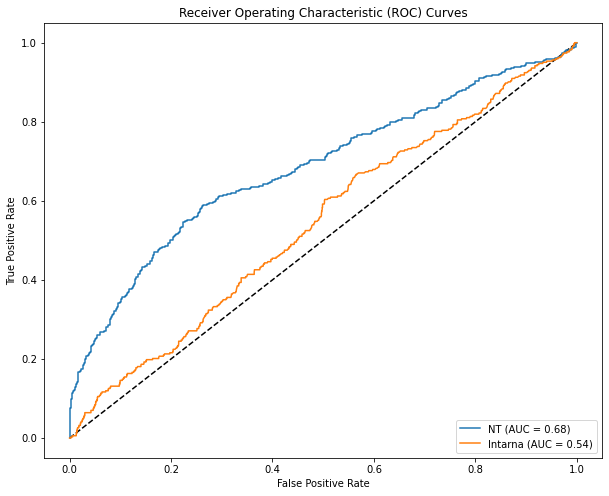

In [23]:
nopc = easypos_smartneg[(easypos_smartneg.gene1_pc == False)|(easypos_smartneg.gene2_pc == False)]
if how =='splash':
    print(nopc.shape[0])
    if nopc.shape[0]>0:
        print(nopc[nopc.ground_truth == nopc.prediction].shape[0]/nopc.shape[0])

else:
    balanced_epsn_nopc = balance_df(nopc)
    print(balanced_epsn_nopc[balanced_epsn_nopc.ground_truth == balanced_epsn_nopc.prediction].shape[0]/balanced_epsn_nopc.shape[0])


    #obtain_plot(balanced_epsn_nopc, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg, at least one is no protein coding',  n_conf = n_conf, excluding_treshold = 0.05)

    plot_roc_curves([{'prob': nopc.probability, 'model_name': 'NT'},
                     {'prob': abs(nopc.E_norm), 'model_name': 'Intarna'}
                    ], nopc.ground_truth)

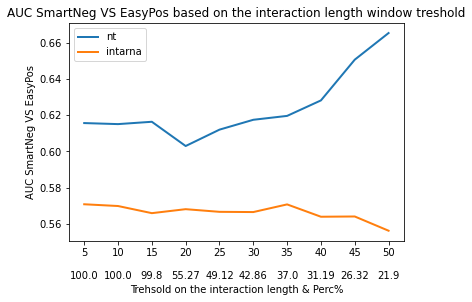

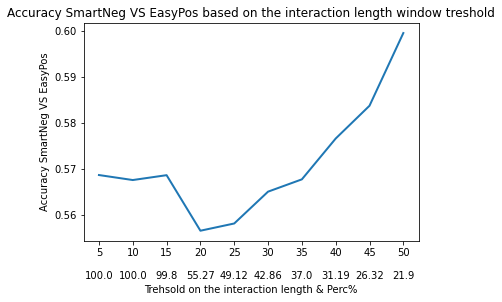

In [24]:
MIN_PERC = 1

def obtain_auc_and_perc(treshold, res, test500, balance = True, intarna = False):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)
    
    if intarna:
        fpr, tpr, _ = roc_curve(abs(1 - res.ground_truth), res.E_norm)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, _ = roc_curve(res.ground_truth, res.probability)
        roc_auc = auc(fpr, tpr)
    
    return roc_auc, perc

def obtain_acc_and_perc(treshold, res, test500, balance = True):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)

    acc = (res.prediction == res.ground_truth).sum()/res.shape[0]
    return acc, perc

tresholds = np.linspace(5, 50, 10).astype(int)
accuracies = []
aucs_nt = []
aucs_intarna = []
percs = []
for treshold in tresholds:
    acc, perc = obtain_acc_and_perc(treshold, easypos_smartneg, test500)
    if perc > MIN_PERC:
        accuracies.append(acc)
        roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = True, intarna = False)
        aucs_nt.append(roc_auc)
        roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = True, intarna = True)
        aucs_intarna.append(roc_auc)
        percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('AUC SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, aucs_nt, label = 'nt', linewidth=2)
plt.plot(merged_x_axis, aucs_intarna, label = 'intarna', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"AUC SmartNeg VS EasyPos")
plt.legend()

plt.show()


merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('Accuracy SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, accuracies, label = 'accuracy', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"Accuracy SmartNeg VS EasyPos")

plt.show()

In [25]:
hn = res[(res.policy == 'hardneg')]

if hn.shape[0]>0:
    print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])
    #obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.8100390407138873


In [26]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

#obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

0.7315199597028083


In [27]:
ep = res[(res.policy == 'easypos')]
print(ep[ep.ground_truth == ep.prediction].shape[0]/ep.shape[0])

#obtain_plot(ep, n_original_df = res.shape[0], title = f'Metrics: accuracy of easypos ', n_conf = n_conf)

0.6032482598607889


In [28]:
sn = res[(res.policy == 'smartneg')]
print(sn[sn.ground_truth == sn.prediction].shape[0]/sn.shape[0])

#obtain_plot(sn, n_original_df = res.shape[0], title = f'Metrics: accuracy of smartneg ', n_conf = n_conf)

0.5324266465180708


0.6883062645011601


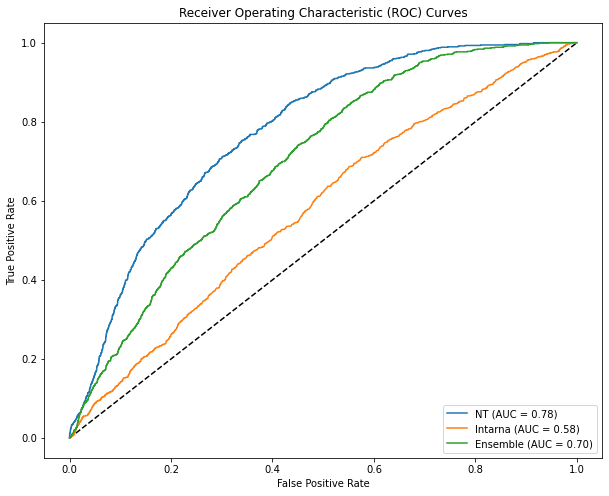

In [29]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

ephnen_sampled = balance_df(ephnen)

print(ephnen_sampled[ephnen_sampled.ground_truth == ephnen_sampled.prediction].shape[0]/ephnen_sampled.shape[0])
#obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)

plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(ephnen_sampled.ensemble_score), 'model_name': 'Ensemble'},
                ], ephnen_sampled.ground_truth)

In [30]:
# confidence_level = 0.7
# high_prob_pairs = easypos_smartneg[(easypos_smartneg.probability>confidence_level)|(easypos_smartneg.probability<(1-confidence_level))]

# obtain_plot(balance_df(high_prob_pairs), n_original_df = easypos_smartneg.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)
# plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

In [31]:
# import dataset.preprocessing as utils
# def order_genes(x):
#     x1, x2 = x.split('_')
#     return utils.get_couple_id(x1, x2)

# prohibited_couples = pd.read_csv(os.path.join(original_files_dir, 'prohibited_couples.txt'), sep = '\t')
# prohibited_couples['messy_id'] = prohibited_couples['gene_id1'] + '_' + prohibited_couples['gene_id2']
# prohibited_couples['id'] = prohibited_couples['messy_id'].apply(order_genes)

# Compare with INTARNA

In [17]:
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)

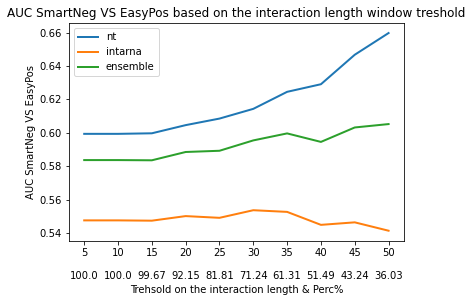

In [8]:
tresholds = np.linspace(5, 50, 10).astype(int)
aucs_nt = []
aucs_intarna = []
aucs_ens = []
percs = []
for treshold in tresholds:
    roc_auc, perc = obtain_auc_and_perc_in_specific_treshold(treshold, easypos_smartneg, test500, balance = False, intarna = False, ensemble = False)
    aucs_nt.append(roc_auc)
    roc_auc, perc = obtain_auc_and_perc_in_specific_treshold(treshold, easypos_smartneg, test500, balance = False, intarna = True, ensemble = False)
    aucs_intarna.append(roc_auc)
    roc_auc, perc = obtain_auc_and_perc_in_specific_treshold(treshold, easypos_smartneg, test500, balance = False, intarna = True, ensemble = True)
    aucs_ens.append(roc_auc)
    percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('AUC SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, aucs_nt, label = 'nt', linewidth=2)
plt.plot(merged_x_axis, aucs_intarna, label = 'intarna', linewidth=2)
plt.plot(merged_x_axis, aucs_ens, label = 'ensemble', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"AUC SmartNeg VS EasyPos")
plt.legend()

In [22]:
#### Compare AUC based on confidence

# plot_intarna_Enorm_curves(res, treshold_plot = -100)

# plot_intarna_Enorm_curves(res, treshold_plot = -2)

In [23]:
#plot_ROC_based_on_confidence(easypos_smartneg, treshold = 0.05)
#plot_ROC_based_on_confidence(easypos_smartneg, how = 'nt', treshold = 0.3)

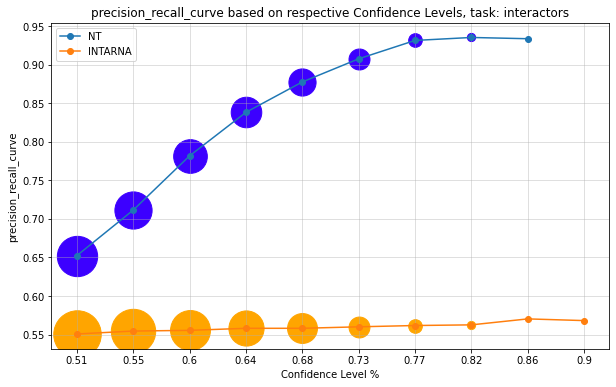

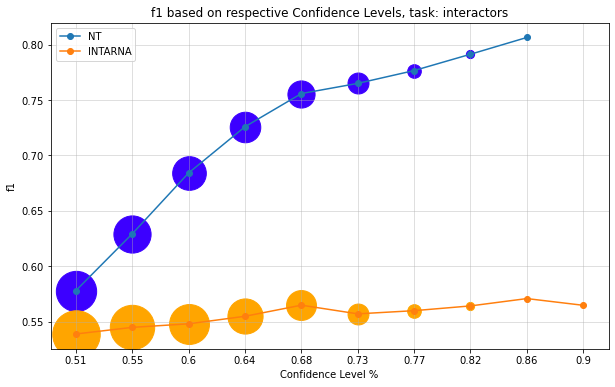

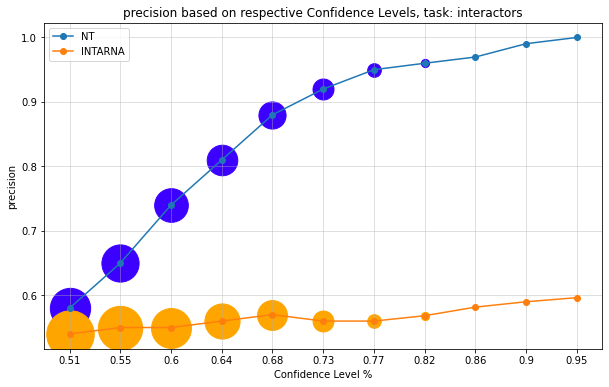

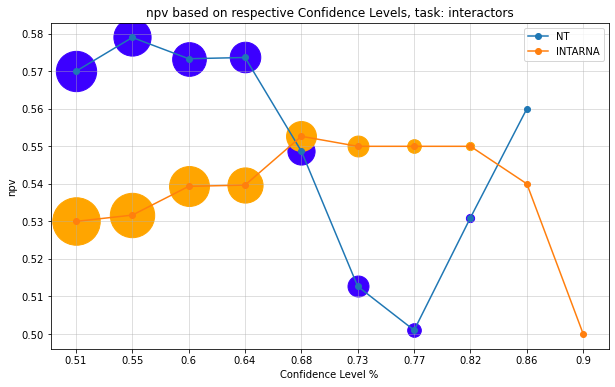

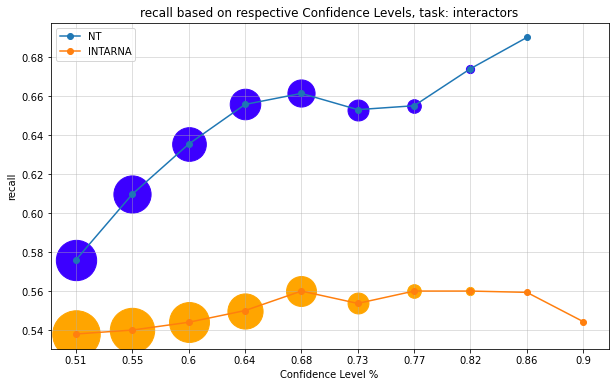

In [28]:
balance_at_the_beginning = True
task = 'interactors'
MIN_PERC = 1
order_by = 'normal' #normal, nt, intarna`
consensus=False
size_multiplier = 30

metrics_to_plot = ['precision_recall_curve', 'f1', 'precision', 'npv', 'recall']

subset = easypos_smartneg.copy()
plot_ens = False

if balance_at_the_beginning:
    
    subset = balance_df(subset).reset_index(drop = True)
    MIN_SAMPLES = int((subset.shape[0] * MIN_PERC) / 100)

    for metric in metrics_to_plot:

        plot_results_based_on_treshold(subset, task, MIN_PERC, MIN_SAMPLES, n_values = 12, size_multiplier = size_multiplier, metric = metric, plot_ens = plot_ens, order_by = order_by, consensus = consensus)

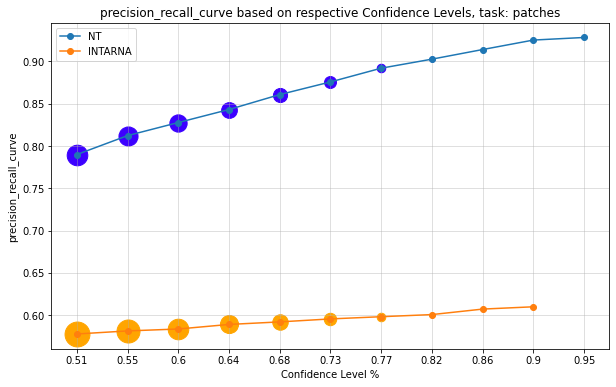

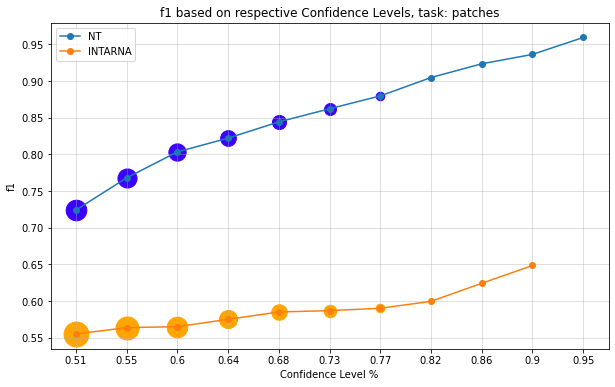

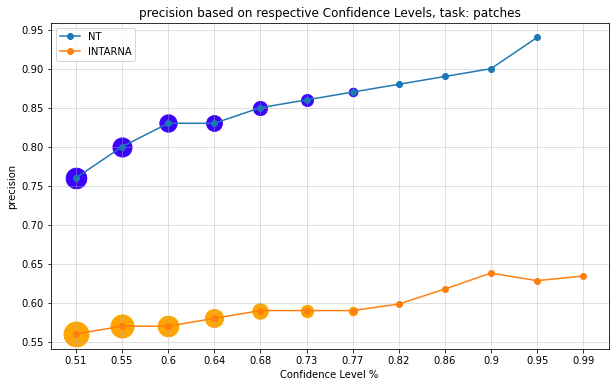

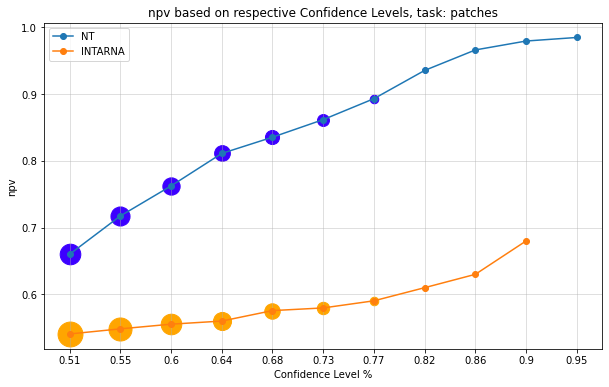

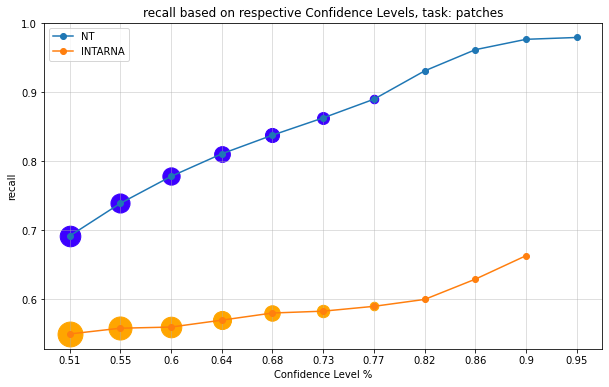

In [29]:
task = 'patches'
subset = ephnen.copy()

if balance_at_the_beginning:
    
    subset = balance_df(subset).reset_index(drop = True)

    MIN_SAMPLES = int((subset.shape[0] * MIN_PERC) / 100)
    
    for metric in metrics_to_plot:

        plot_results_based_on_treshold(subset, task, MIN_PERC, MIN_SAMPLES, n_values = 12, size_multiplier = 10, metric = metric, plot_ens = plot_ens)

### Pathches task dependence on the distance from the interaction site

<AxesSubplot:>

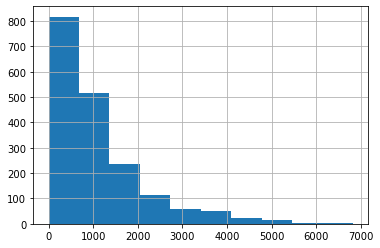

In [20]:
test500['distance_from_site'] = ( (test500['distance_x'] ** 2) + (test500['distance_y']** 2) )**(0.5) #pitagora
test500[test500.policy.isin(['hardneg', 'easyneg'])].distance_from_site.hist()

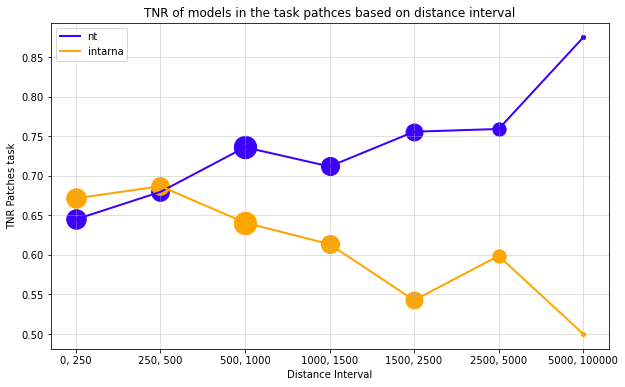

In [21]:
bins_distance = [[0, 250], [250, 500], [500, 1_000], [1_000, 1_500], [1_500, 2_500], [2_500, 5_000], [5_000, 100_000]]
plot_tnr_based_on_distance(test500, ephnen, bins_distance)

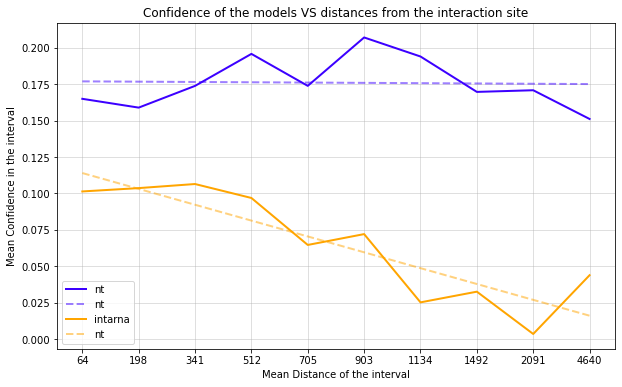

In [22]:
n_values = 10
bins_distance = quantile_bins(test500[test500.policy.isin(['hardneg', 'easyneg'])].distance_from_site, n_values)

plot_confidence_based_on_distance(test500, ephnen, bins_distance)

# Repeats enrichment

In [ ]:
feature_to_search = 'Simple_repeat' #'Simple_repeat' 'Low_complexity' 'SINE'

full_overlap = False

if full_overlap:
    suffix = 'full_'
else:
    suffix = ''

sr1 = test500[test500[f'{suffix}feature1'].apply(lambda x: feature_to_search in x)].couples
sr2 = test500[test500[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)].couples

none1 = test500[test500[f'{suffix}feature1'].apply(lambda x: 'None' in x)].couples
none2 = test500[test500[f'{suffix}feature2'].apply(lambda x: 'None' in x)].couples

res['simple_repeat1'] = res.id_sample.isin(sr1)
res['simple_repeat2'] = res.id_sample.isin(sr2)
res['none1'] = res.id_sample.isin(none1)
res['none2'] = res.id_sample.isin(none2)

In [100]:
both_sr = False

filtered_policies = ['easypos']

if both_sr:
    sr = res[res['simple_repeat1'] & res['simple_repeat2']]
else:
    sr = res[res['simple_repeat1'] | res['simple_repeat2']]
no_sr = res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)] #res[res['none1'] & res['none2']] #res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)]

sr = sr[sr.policy.isin(filtered_policies)].reset_index(drop = True)
no_sr = no_sr[no_sr.policy.isin(filtered_policies)].reset_index(drop = True)

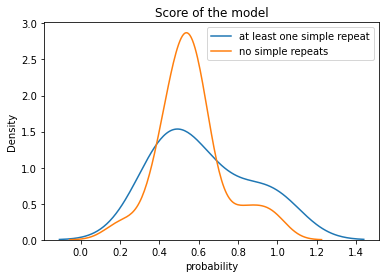

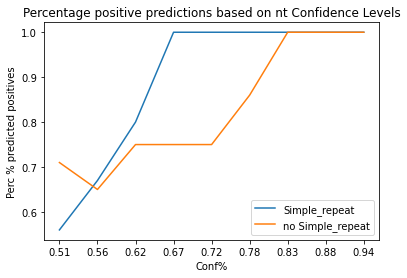

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.24932249322493225
P-value: 0.6570875533445568

Test di Mann-Whitney U:
Statistiche U: 196.0
P-value: 0.7811890699495541


In [101]:
order = 'nt'

assert order in ['nt', 'intarna', 'ensemble']

if order == 'nt':
    x, y = sr['probability'], no_sr['probability']
elif order == 'intarna':
    x, y = abs(sr['E_norm']), abs(no_sr['E_norm'])
elif order == 'ensemble':
    x, y = abs(sr['ensemble_score']), abs(no_sr['ensemble_score'])

if both_sr:
    label = f'both {feature_to_search}'
else:
    label = f'at least {feature_to_search}'
    
sns.kdeplot(x, common_norm=True, label = label if both_sr else 'at least one simple repeat')
sns.kdeplot(y, common_norm=True,  label = 'no simple repeats')

plt.title(f'Score of the model')
plt.legend()
plt.show()

conf_space1, perc_1_sr = collect_results_based_on_confidence_level_how_many1(sr, how = order, MIN_PERC = MIN_PERC, balance = False, n_values = 10, space = 'linear', intarna_treshold = intarna_treshold)
conf_space2, perc_1_nosr = collect_results_based_on_confidence_level_how_many1(no_sr, how = order, MIN_PERC = MIN_PERC, balance = False, n_values = 10, space = 'linear', intarna_treshold = intarna_treshold)

set_comuni = set(conf_space1) & set(conf_space2)

conf_space = [conf_space1[i] for i in range(len(conf_space1)) if conf_space1[i] in set_comuni]
perc_1_sr = [perc_1_sr[i] for i in range(len(conf_space1)) if conf_space1[i] in set_comuni]
perc_1_nosr = [perc_1_nosr[i] for i in range(len(conf_space2)) if conf_space2[i] in set_comuni]

plt.plot(conf_space, perc_1_sr, label = feature_to_search)
plt.plot(conf_space, perc_1_nosr, label = f'no {feature_to_search}')
plt.title(f'Percentage positive predictions based on {order} Confidence Levels')
plt.legend()
plt.ylabel('Perc % predicted positives')
plt.xlabel(f"Conf%")
plt.show()

# Test di Kolmogorov-Smirnov
ks_statistic, ks_p_value = stats.ks_2samp(x, y)
print(f"Test di Kolmogorov-Smirnov:\nStatistiche KS: {ks_statistic}\nP-value: {ks_p_value}\n")

# Test di Mann-Whitney U
mwu_statistic, mwu_p_value = stats.mannwhitneyu(x, y, alternative='two-sided')
print(f"Test di Mann-Whitney U:\nStatistiche U: {mwu_statistic}\nP-value: {mwu_p_value}")

In [41]:
if how == 'splash':
    df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats_splash.csv'))
elif how in ['mario', 'ricseq']:
    df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats.csv'))

#check to assert that all our repeats are correctly annotated
to_check = sr[(sr.simple_repeat1 == True) & (sr.simple_repeat2 == True) ]

for _, row in to_check.iterrows():

    if len(test500[test500.couples == row.id_sample]) == 1:
        row_test500 = test500[test500.couples == row.id_sample].iloc[0]
        subset_rep = df_repeats[df_repeats.gene_id == row.gene1_original]

        found1 = False
        for _, s_row in subset_rep.iterrows():
            if len(set(range(s_row.start, s_row.end)).intersection(set(range(row_test500['x1'] - 1, row_test500['x2'] + 1)))) > 0:
                found1 = True

        assert found1 == True

        subset_rep = df_repeats[df_repeats.gene_id == row.gene2_original]
        found2 = False
        for _, s_row in subset_rep.iterrows():
            if len(set(range(s_row.start, s_row.end)).intersection(set(range(row_test500['y1'] - 1, row_test500['y2'] + 1))))>0:
                found2 = True

        assert found2 == True

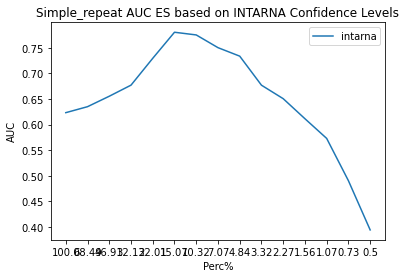

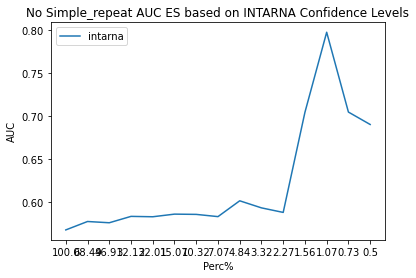

In [42]:
# AUC easypossmartneg
both_sr = False

filtered_policies = ['smartneg', 'easypos']

if both_sr:
    sr = res[res['simple_repeat1'] & res['simple_repeat2']]
else:
    sr = res[res['simple_repeat1'] | res['simple_repeat2']]

no_sr = res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)] #res[res['none1'] & res['none2']] #res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)]

sr = sr[sr.policy.isin(filtered_policies)].reset_index(drop = True)
no_sr = no_sr[no_sr.policy.isin(filtered_policies)].reset_index(drop = True)

confidence_level, auc_nt, auc_intarna, auc_ens = collect_results_based_on_confidence_level(sr, how = 'intarna', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = 'log')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
# plt.plot(confidence_level, auc_nt, label = 'nt')
# plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title(f'{feature_to_search} AUC ES based on INTARNA Confidence Levels')
plt.legend()
plt.ylabel('AUC')
plt.xlabel(f"Perc%")
plt.show()


confidence_level, auc_nt, auc_intarna, auc_ens = collect_results_based_on_confidence_level(no_sr, how = 'intarna', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = 'log')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
# plt.plot(confidence_level, auc_nt, label = 'nt')
# plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title(f'No {feature_to_search} AUC ES based on INTARNA Confidence Levels')
plt.legend()
plt.ylabel('AUC')
plt.xlabel(f"Perc%")
plt.show()

# XAI

In [97]:
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'))

DEVICE = 'cpu'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT2(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=512, bias=True)
    )
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=512, out_features=800, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(800, 300, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(300, 300, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
    (global_avg_pool): AdaptiveAvgPool2d(

In [98]:
xai = pd.read_csv(os.path.join(checkpoint_dir, f'gradcam_results_{how}500.csv'))
xai = xai.merge(res.filter([
    'couples', 'gene1_pc', 'gene2_pc', 'original_length1', 'original_length2', 'id_sample', 'g1', 'g2', 'gene1_original', 'gene2_original'
], axis = 1), left_on = 'id', right_on = 'id_sample')

In [99]:
gradcam_results = xai[xai.probability>0.5]

iou_value: 0.0293
iou_value_tr: 0.0269
iou_value_rand: 0.0177


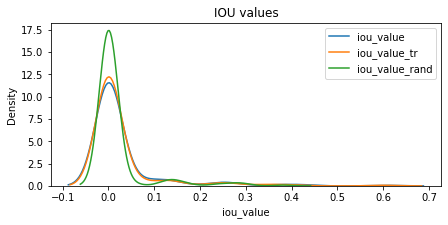

intensity: 0.4433
intensity_tr: 0.1598
intensity_rand: 0.4999


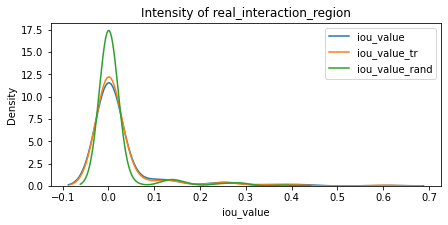

euclidean: 0.4676
euclidean_rand: 0.5099
euclidean_bbox_tr: 0.4664


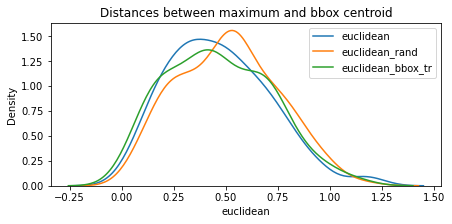

cos_sim: 0.15
cos_sim_tr: 0.09
cos_sim_rand: 0.13


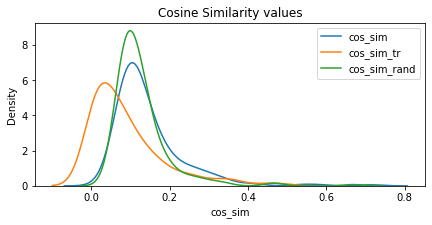

In [100]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_rand']
for c in iou_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

intensity_columns = ['intensity', 'intensity_tr', 'intensity_rand']
for c in intensity_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
    
plt.title(f'Intensity of real_interaction_region')
plt.legend()
plt.show()

euclidean_columns = ['euclidean', 'euclidean_rand', 'euclidean_bbox_tr']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid')
plt.legend()
plt.show()

cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_rand']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 2))}')

for c in cosine_sim_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()

#### Subset XAI results

euclidean: 0.4676
euclidean_rand: 0.5099


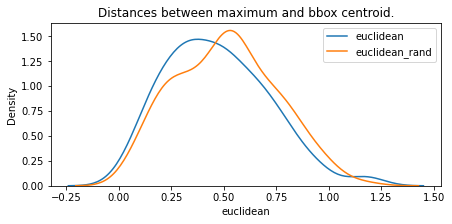

In [101]:
gradcam_results = gradcam_results[(gradcam_results.probability>0.5)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid.')
plt.legend()
plt.show()

In [102]:
def plot_query_results(query):
    for _, row in query.iterrows():
        x1_emb, x2_emb, y1_emb, y2_emb = int(np.round(row.x1/6)), int(np.round(row.x2/6)), int(np.round(row.y1/6)), int(np.round(row.y2/6))
        
        embedding1_path = os.path.join(embedding_dir, '32', row.gene1+'.npy')
        embedding2_path = os.path.join(embedding_dir, '32', row.gene2+'.npy')

        embedding1 = np.load(embedding1_path)[x1_emb:x2_emb :]
        embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]

        rna1, rna2 = torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
        rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)

        rna1, rna2 = rna1.to(device), rna2.to(device)
        
        outputs = model(rna1, rna2)

        outputs[:, 1].backward()
        #print('prob:', outputs.softmax(-1)[:, 1])
        #print('degree:', row.abs_sum_diff)
        x1 = int(row.seed_x1-row.x1)
        x2 = int(row.seed_x2-row.x1)
        y1 = int(row.seed_y1-row.y1)
        y2 = int(row.seed_y2-row.y1)
        width = row.len1
        height = row.len2
        

        expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)
        
        expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height=height, width=width)
        
        # print(x1, x2, y1, y2)
        # print(expl_matrix_reshaped.shape)

        scaling_factor = 70

        plot_matrix(expl_matrix_reshaped, 
        [[y1, x1, y2-y1, x2-x1]], #crop_bbox =[x1hat, y1hat, what, hhat], 
        cmap ='viridis', 
        scaling_factor = scaling_factor)
        plt.show()

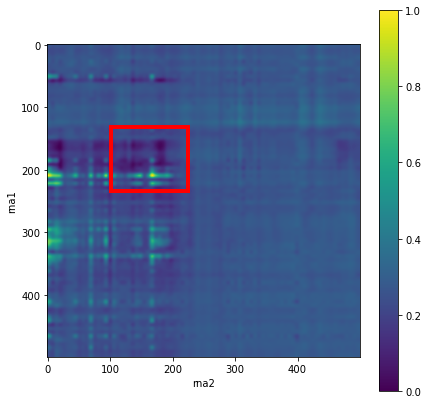

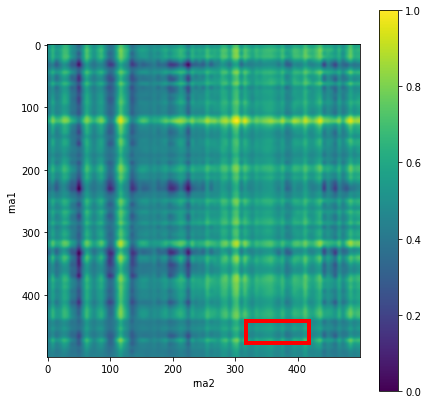

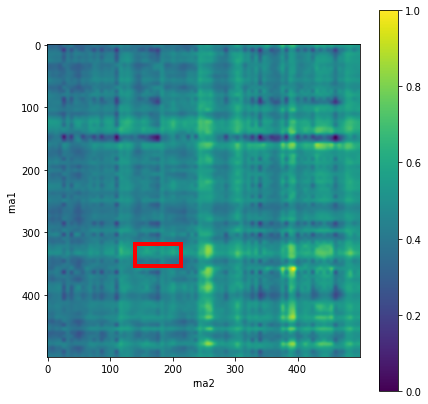

In [ ]:
N_plots = max(10, gradcam_results.shape[0])
query = test500[test500.couples.isin(list(gradcam_results.sample(N_plots).id))]
plot_query_results(query)

euclidean: 0.4825
euclidean_rand: 0.7092


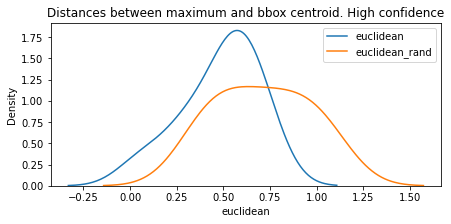

In [52]:
n_best = 10

gradcam_results = xai.sort_values('probability').tail(n_best)
#gradcam_results = xai.sort_values('iou_value').tail(n_best)
#gradcam_results = xai[(xai.probability>0.6)&(xai.probability<0.77)].sample(n_best)

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. High confidence')
plt.legend()
plt.show()

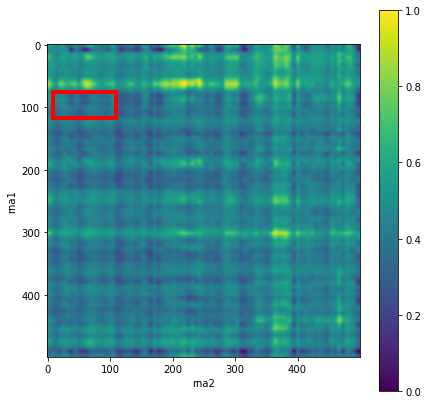

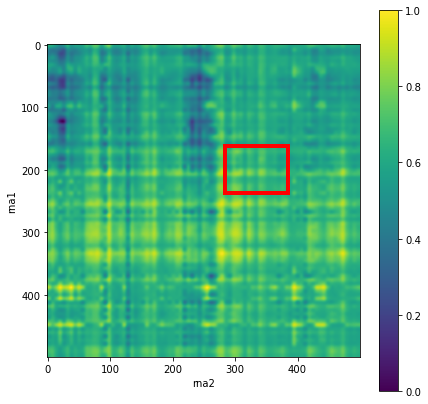

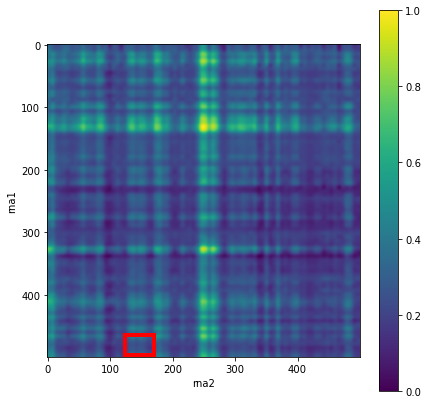

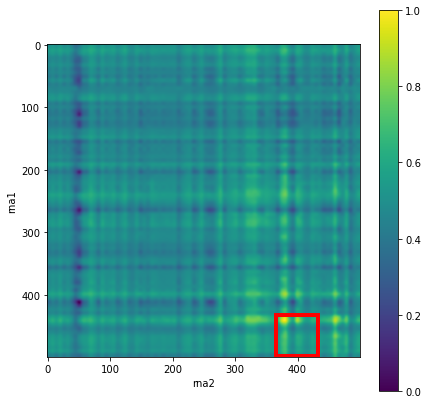

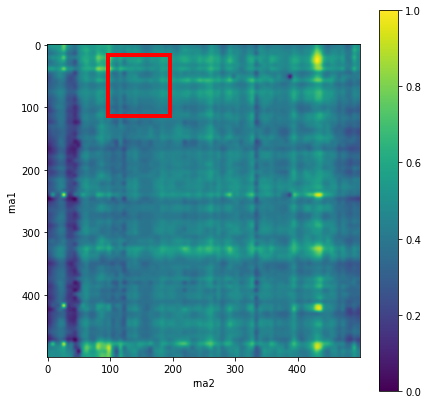

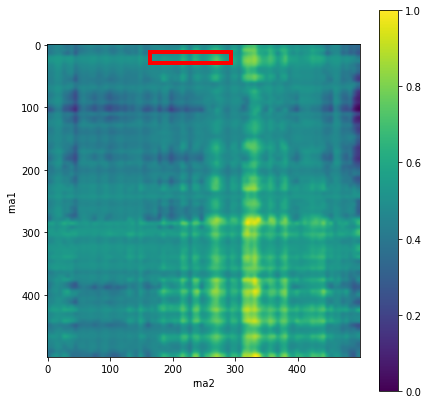

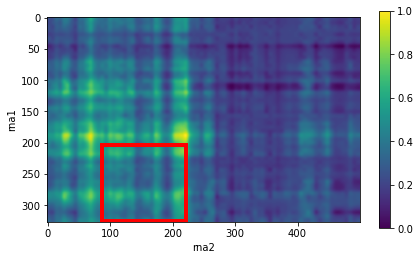

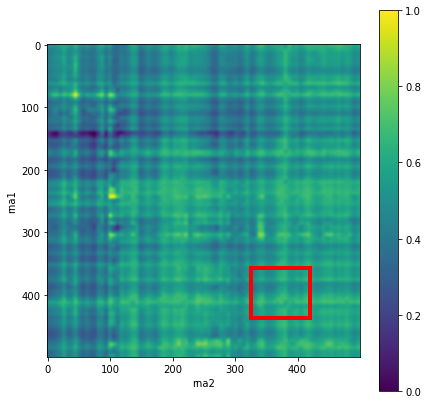

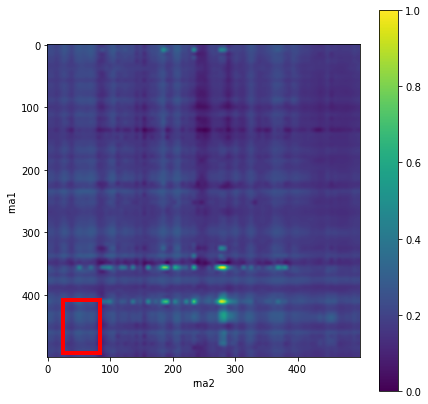

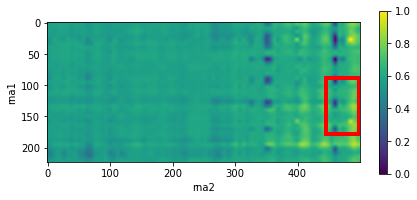

In [53]:
query = test500[test500.couples.isin(list(gradcam_results.id))]
plot_query_results(query)